# Упражнение 1. Работа с API

Есть проект "Конструктор ОП" http://op.itmo.ru

## Задание 1.0

Доступ к контенту появляется после регистрации. Можно войти через ИСУ, первый вход = регистрация. Для целей лабораторной работы можно либо создать пользователя, либо воспользоваться тестовым.

В процессе работы нужно будет получить данные по API. Собрать по этим данным датасет (например, можно воспользоваться библиотекой pandas). После провести первичный анализ и сделать визуализации.

In [ ]:
import requests
import json
import pandas as pd
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)
url = "https://op.itmo.ru/auth/token/login"
auth_data = {"username": "analytic", "password": "datatest"}
token_txt = requests.post(url, auth_data).text
token = json.loads(token_txt)["auth_token"]
headers = {'Content-Type': "application/json", 'Authorization': "Token " + token}

## Задание 1.1 Получить идентификаторы всех учебных планов, имеющихся в op.itmo.ru

Для начала сделаем обработку данных с сайта, использующего пагинацию. Для этого итеративно просматриваем результат запроса на каждую из страниц, выводим номер страницы, число найденных планов, общее число найденных планов и записываем результаты в data.

In [ ]:
import requests
import re
data = []
regular = '(?<=page=)(.*)'
url = 'http://op.itmo.ru/api/record/academic_plan/academic_wp_description/all?page=1'
valid = True
while valid:
  log = ''
  response = requests.get(url, headers=headers)
  response_data = response.json()
  log += f'Страница: {re.search(regular, url).group(1)} '
  if (response_data['next'] != None):
    url = response_data['next']
  else:
    valid = False
  results = response_data['results']
  log += f'Найдено планов: {len(results)} '
  data.extend(results)
  log += f'Всего планов: {len(data)}'
  print(log)

Страница: 1 Найдено планов: 10 Всего планов: 10
Страница: 2 Найдено планов: 10 Всего планов: 20
Страница: 3 Найдено планов: 10 Всего планов: 30
Страница: 4 Найдено планов: 10 Всего планов: 40
Страница: 5 Найдено планов: 10 Всего планов: 50
Страница: 6 Найдено планов: 10 Всего планов: 60
Страница: 7 Найдено планов: 10 Всего планов: 70
Страница: 8 Найдено планов: 10 Всего планов: 80
Страница: 9 Найдено планов: 10 Всего планов: 90
Страница: 10 Найдено планов: 10 Всего планов: 100
Страница: 11 Найдено планов: 10 Всего планов: 110
Страница: 12 Найдено планов: 10 Всего планов: 120
Страница: 13 Найдено планов: 10 Всего планов: 130
Страница: 14 Найдено планов: 10 Всего планов: 140
Страница: 15 Найдено планов: 10 Всего планов: 150
Страница: 16 Найдено планов: 10 Всего планов: 160
Страница: 17 Найдено планов: 10 Всего планов: 170
Страница: 18 Найдено планов: 10 Всего планов: 180
Страница: 19 Найдено планов: 10 Всего планов: 190
Страница: 20 Найдено планов: 10 Всего планов: 200
Страница: 21 Найде

Выберем только id из каждой записи

In [ ]:
id_list = list(map(lambda element: { 'id': element['id'] }, data))

И преобразуем в dataframe

In [ ]:
df = pd.DataFrame(id_list).reset_index(drop=True)

Выведем все полученные id планов

In [ ]:
df

,id
0,6796
1,6797
2,6798
3,6799
4,6800
...,...
584,7399
585,7395
586,7493
587,7319


## Задание 1.2 По этим планам получить детальное описание

Получим детальное описание для каждого плана по id из предыдущего шага и итеративно добавим в detail_data

In [ ]:
import requests
detail_data = []
cnt = 0
for element in id_list:
  plan_id = element.get('id')
  cnt += 1
  # print(str(cnt) + ') Учебный план: ' + str(plan_id))
  url = f'https://op.itmo.ru/api/academicplan/detail/{plan_id}'
  response = requests.get(url)
  detail_data.append(response.json())

Преобразуем в dataframe, выделив поля, используемые далее, в отдельные столбцы (для элементов, чье значение может отсутствовать присутствует замена на None в случае строки и 0 в случае id)

In [ ]:
df_details = [element.get('academic_plan_in_field_of_study')[0] for element in detail_data]
df['study_id'] = [element['id'] for element in df_details]
df['year'] = [element['year'] for element in df_details]
df['qualification'] = [element['qualification'] for element in df_details]
df['structural_isu_id'] = [int(element['structural_unit']['isu_id']) if element['structural_unit'] else 0 for element in df_details]
df['structural_title'] = [element['structural_unit']['title'] if element['structural_unit'] else None for element in df_details]
df['structural_short_name'] = [element['structural_unit']['short_name'] if element['structural_unit'] else None for element in df_details]
df['on_check'] = [element['on_check'] for element in detail_data]
df['was_send_to_isu'] = [element['was_send_to_isu'] for element in detail_data]
df

,id,study_id,year,qualification,structural_isu_id,structural_title,structural_short_name,on_check,was_send_to_isu
0,6796,6859,2018,bachelor,0,None,None,in_work,False
1,6797,6860,2018,bachelor,0,None,None,in_work,False
2,6798,6861,2021,master,0,None,None,in_work,False
3,6799,6862,2018,bachelor,0,None,None,in_work,False
4,6800,6863,2018,bachelor,0,None,None,in_work,False
...,...,...,...,...,...,...,...,...,...
584,7399,7463,2023,master,761,факультет систем управления и робототехники,ФСУ и Р,verified,True
585,7395,7459,2023,master,980,химико-биологический кластер,ХБК,verified,True
586,7493,7646,2023,bachelor,776,факультет цифровых трансформаций,ФЦТ,verified,True
587,7319,7383,2023,bachelor,762,факультет программной инженерии и компьютерной техники,ФПИ и КТ,verified,True


## Задание 1.3 Построить графики

Построить графики: количество планов по годам набора, квалификациям и структурным подразделениям.

Сгруппируем по годам и добавим столбец с количеством по каждой группе

In [ ]:
import matplotlib.pyplot as plt
df_plans = df.groupby(['year']).size().reset_index(name='plans')

Построим график зависимости количества планов от года набора


<Figure size 1080x432 with 0 Axes>

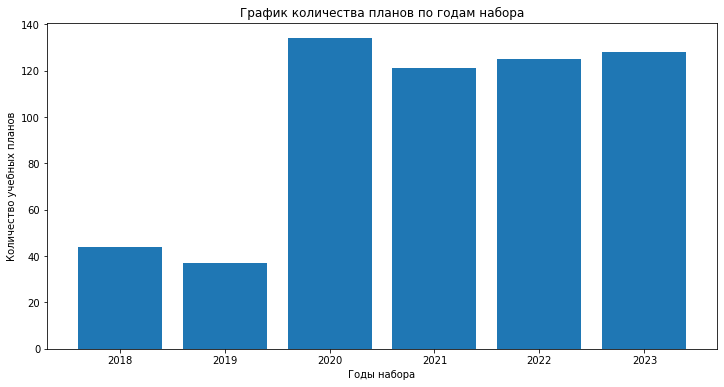

In [ ]:
plt.figure(figsize=(15, 6))
x = df_plans['year']
y = df_plans['plans']
fig, ax = plt.subplots()

ax.bar(x, y)

fig.set_figwidth(12)
fig.set_figheight(6)

plt.title('График количества планов по годам набора')
plt.xlabel('Годы набора')
plt.ylabel('Количество учебных планов')
plt.show()


Как можно заметить, начиная с 2020 года количество планов резко увеличилось, по сравнению с 2018 и 2019 годами. Скорее всего связано с тем, что до 2020 года не загружались магистерские учебные планы.

Теперь сгруппируем планы по квалификациям и добавим столбец с количеством в каждой группе

In [ ]:
df_qualification = df.groupby(['qualification']).size().reset_index(name='plans')

Построим график зависимости количества планов от квалификации

<Figure size 1080x432 with 0 Axes>

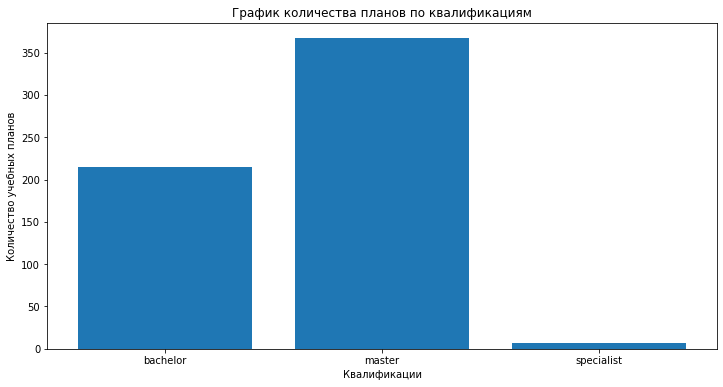

In [ ]:
plt.figure(figsize=(15, 6))
x = df_qualification['qualification']
y = df_qualification['plans']
fig, ax = plt.subplots()

ax.bar(x, y)

fig.set_figwidth(12)
fig.set_figheight(6)

plt.title('График количества планов по квалификациям')
plt.xlabel('Квалификации')
plt.ylabel('Количество учебных планов')
plt.show()

Как можно заметить, меньше всего планов составлено для специалитета, больше всего для магистратуры. Бакалавриат занял второй место

Теперь сгруппируем планы по короткому имени и id структурного подразделения и добавим столбец с количеством в каждой группе

In [ ]:
df_structure = df.groupby(['structural_short_name', 'structural_isu_id']).size().reset_index(name='plans')

Построи график количества планов по структурным подразделениям (каждый столбец в столбчатой диаграмме под каждое подразделение с указанием короткого наименования и кода)

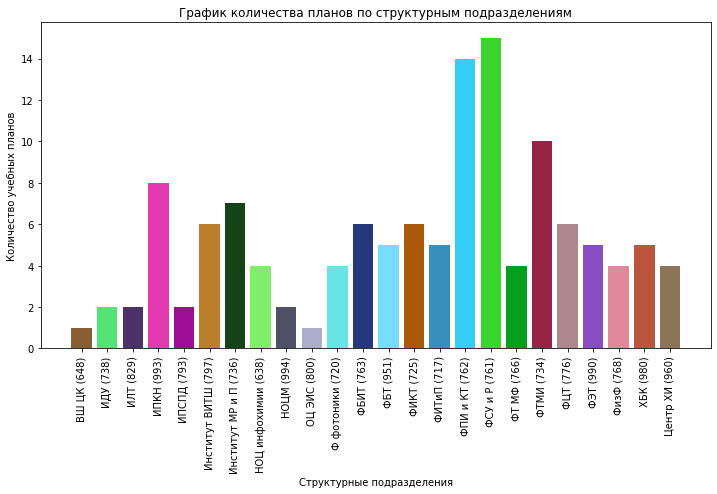

In [ ]:
import numpy as np
y = df_structure['plans'].values.tolist()
x = df_structure['structural_short_name'].values.tolist()
z = df_structure['structural_isu_id'].values.tolist()
for i in range(0, len(x)):
  x[i] = f'{x[i]} ({z[i]})'
fig, ax = plt.subplots()

color_rectangle = np.random.rand(len(df_structure), 3)
ax.bar(x, y, color = color_rectangle)

fig.set_figwidth(12)
fig.set_figheight(6)

plt.title('График количества планов по структурным подразделениям')
plt.xlabel('Структурные подразделения')
plt.ylabel('Количество учебных планов')
plt.xticks(rotation=90)

plt.show()

Как можно заметить, наибольшим количеством планов обладает подразделение ФСУ и Р с кодом 761, наименьшим - ВШ ЦК с кодом 648 и ОЦ ЭИС с кодом 800

## Задание 1.4 Анализ

Для планов 2023 года набора построить график с распределением статусов "on_check" и "was_send_to_isu". Вывести ID и название структурного подразделения для а) не принятых, б) не отправленных планов

Отфильтруем планы по 2023 году

In [ ]:
df_year=df.query("`year` == 2023").reset_index(drop=True)


Составим сначала dataframe из необходимых параметров и переименуем колонки для удобства. Затем:

1) Для каждого из статусов "on_check" сгруппируем данные по id и короткому наименованию структурного подразделения и добавим отдельный столбец с количеством для каждой группы

2) Для каждого из состояний "was_send_to_isu" (True и False) сгруппируем данные по id и короткому наименованию структурного подразделения и добавим отдельный столбец с количеством для каждой группы

In [ ]:
dataset = df_year[['structural_isu_id', 'structural_short_name', 'on_check', 'was_send_to_isu']].copy()
dataset.columns = ['structure', 'name', 'status', 'sended']
daver = dataset.query("`status` == 'verified'").groupby(['structure', 'name']).size().reset_index(name='count')
dawork = dataset.query("`status` == 'in_work'").groupby(['structure', 'name']).size().reset_index(name='count')
dacheck = dataset.query("`status` == 'on_check'").groupby(['structure', 'name']).size().reset_index(name='count')

dasend = dataset.query("`sended` == True").groupby(['structure', 'name']).size().reset_index(name='count')
danotsend = dataset.query("`sended` != True").groupby(['structure', 'name']).size().reset_index(name='count')

1) Построим график зависимости количества планов от статуса on_check по структурным подразделениям с распределением по цветам в зависимости от статуса, указанного в легенде

2) Построим график зависимости количества планов от статуса was_send_to_isu по структурным подразделениям с распределением по цветам в зависимости от статуса, указанного в легенде

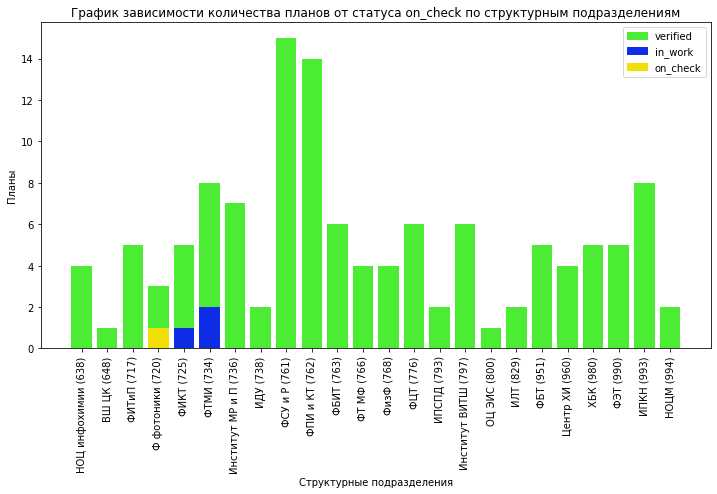

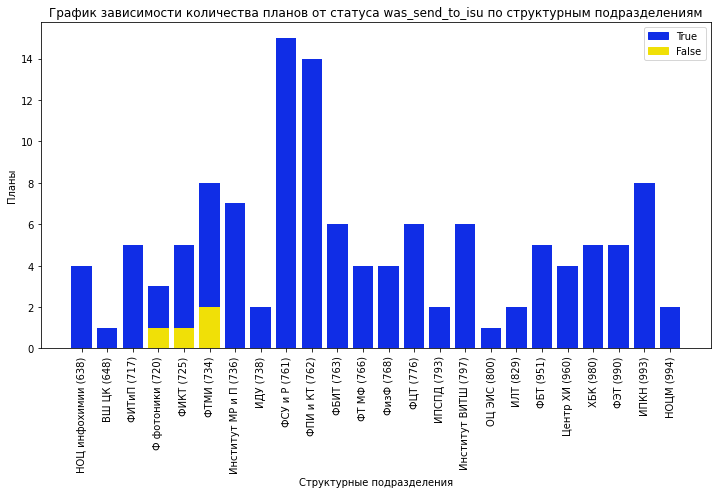

In [ ]:
import numpy as np
import matplotlib.patches as mpatches


def plot(ax, dataframe, xframe, yframe, color, width, label, additional=''):
  y = dataframe[yframe].values.tolist()
  x = dataframe[xframe].values.tolist()
  if additional != '':
    z = dataframe[additional].values.tolist()
    for i in range(0, len(x)):
      x[i] = f'{x[i]} ({z[i]})'
  ax.bar(x, y, color=color, width=width)
  if label != '':
    return mpatches.Patch(color=color, label=label)

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(6)
plt.title('График зависимости количества планов от статуса on_check по структурным подразделениям')
plt.xlabel('Структурные подразделения')
plt.ylabel('Планы')
plt.xticks(rotation=90)


patches=[]
patches.append(plot(ax, daver, 'name', 'count', "#4ceb34", 0.8, 'verified', 'structure'))
patches.append(plot(ax, dawork, 'name', 'count', "#102de6", 0.8, 'in_work', 'structure'))
patches.append(plot(ax, dacheck, 'name', 'count', "#f0e007", 0.8, 'on_check', 'structure'))

plt.legend(handles=patches)
plt.show()


fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(6)
plt.title('График зависимости количества планов от статуса was_send_to_isu по структурным подразделениям')
plt.xlabel('Структурные подразделения')
plt.ylabel('Планы')
plt.xticks(rotation=90)


patches=[]
patches.append(plot(ax, dasend, 'name', 'count', "#102de6", 0.8, 'True', 'structure'))
patches.append(plot(ax, danotsend, 'name', 'count', "#f0e007", 0.8, 'False', 'structure'))

plt.legend(handles=patches)
plt.show()

Из первого графика мы видим, что большинство планов было утверждено. И наименьшее количество проверяется. При этом стоит отметить, что структурные подразделения ФИКТ с кодом 725 и ФТМИ с кодом 734 наибольшим образом отстают от других по скорости работы над утверждением планов.

Из второго графика мы видим, что большинство подразделений отправило в isu свои планы. Стоит отметить, что, как и говорилось ранее, часть структурных подразделений не справилось с задачей по полному утверждению всех планов, в следствие чего из текущего графика можно сделать вывод о том, что ФИКТ с кодом 725, ФТМИ с кодом 734 и Ф фотоники с кодом 720 все еще не отправили часть планов в isu.

Выведем id плана, id и название структурного подразделения для:

а) не принятых планов

In [ ]:
#a)
df_year.query("`on_check` != 'verified'")[['id', 'structural_isu_id', 'structural_title']].reset_index(drop=True)

,id,structural_isu_id,structural_title
0,7402,734,факультет технологического менеджмента и иннов...
1,7403,734,факультет технологического менеджмента и иннов...
2,7484,725,факультет инфокоммуникационных технологий
3,7495,720,факультет фотоники


б) не отправленных планов

In [ ]:
#b)
df_year.query("`was_send_to_isu` == False")[['id', 'structural_isu_id', 'structural_title']].reset_index(drop=True)

,id,structural_isu_id,structural_title
0,7402,734,факультет технологического менеджмента и иннов...
1,7403,734,факультет технологического менеджмента и иннов...
2,7484,725,факультет инфокоммуникационных технологий
3,7495,720,факультет фотоники
